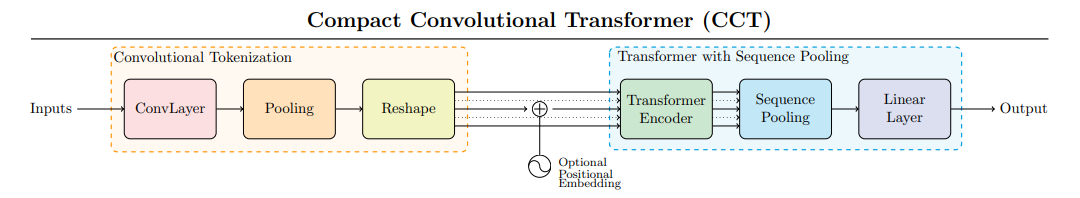

In [28]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torchinfo

In [1]:
import torch.optim as optim
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F #funciones de activacion
import math

#from pytorch_model_summary import summary
from torchvision.utils import save_image
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

import gc
import time

In [3]:
data_dir = './FRUIT-16K'

transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Redimensionar las imágenes
    transforms.ToTensor()          # Convertir las imágenes a tensores
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalización
])

# Cargar el dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

#SPLIT DATASET
generator1 = torch.Generator().manual_seed(42)
train_size = int(0.8 * len(dataset))  # 80% para entrenamiento
valid_size = len(dataset) - train_size  # 20% para validación
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size], generator=generator1)

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

print(f'Tamaño del dataset de entrenamiento: {len(train_dataset)}')
print(f'Tamaño del dataset de validación: {len(valid_dataset)}')

Tamaño del dataset de entrenamiento: 12800
Tamaño del dataset de validación: 3200


# Modelo

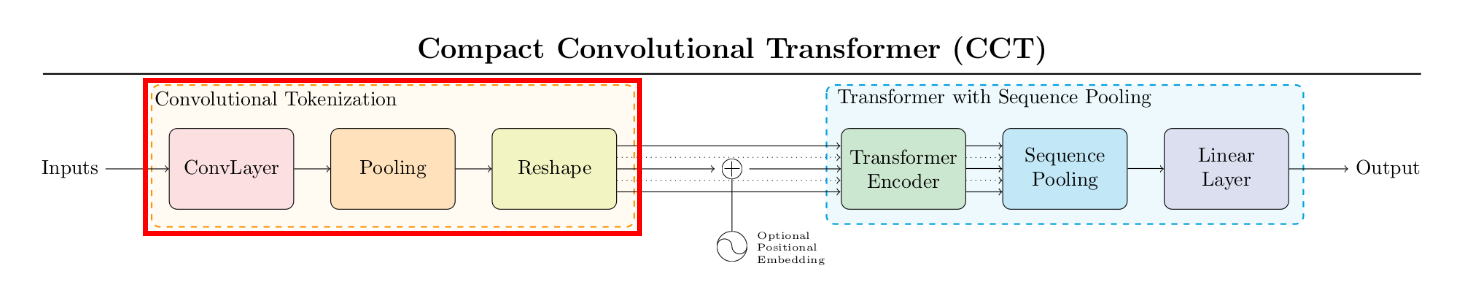

In [4]:
class Tokenizer(nn.Module):
    def __init__(self,
                 kernel_size, stride, padding,
                 pooling_kernel_size=3, pooling_stride=2, pooling_padding=1,
                 n_conv_layers=1,
                 n_input_channels=3,
                 n_output_channels=64,
                 in_planes=64,
                 activation=None,
                 max_pool=True,
                 conv_bias=False):
        super(Tokenizer, self).__init__()

        n_filter_list = [n_input_channels] + \
                        [in_planes for _ in range(n_conv_layers - 1)] + \
                        [n_output_channels]


        self.conv_layers = nn.Sequential(
            *[nn.Sequential(
                nn.Conv2d(n_filter_list[i], n_filter_list[i + 1],
                          kernel_size=(kernel_size, kernel_size),
                          stride=(stride, stride),
                          padding=(padding, padding), bias=conv_bias),
                nn.Identity() if activation is None else activation(),
                nn.MaxPool2d(kernel_size=pooling_kernel_size,
                             stride=pooling_stride,
                             padding=pooling_padding) if max_pool else nn.Identity()
            )
                for i in range(n_conv_layers)
        ])



        self.flattener = nn.Flatten(2, 3)

    def sequence_length(self, n_channels=3, height=224, width=224):
        return self.forward(torch.zeros((1, n_channels, height, width))).shape[1]

    def forward(self, x):
        return self.flattener(self.conv_layers(x)).transpose(-2, -1)

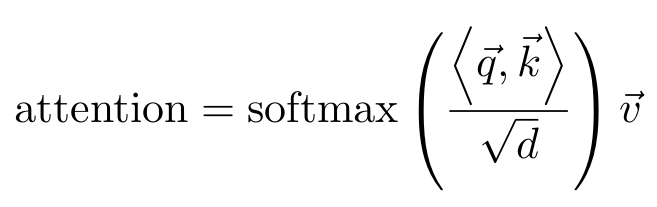

In [5]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, attention_dropout=0.1, projection_dropout=0.1): # dim = 768
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // self.num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3)
        self.attn_drop = nn.Dropout(attention_dropout)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(projection_dropout)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, #qkv
                                                                                        0, #batch
                                                                                        3, #canal
                                                                                        1, #num_heads
                                                                                        4) #embed_dim
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        out = (attn @ v).transpose(1, 2).reshape(B, N, C)
        out = self.proj(out)
        out = self.proj_drop(out)
        return out

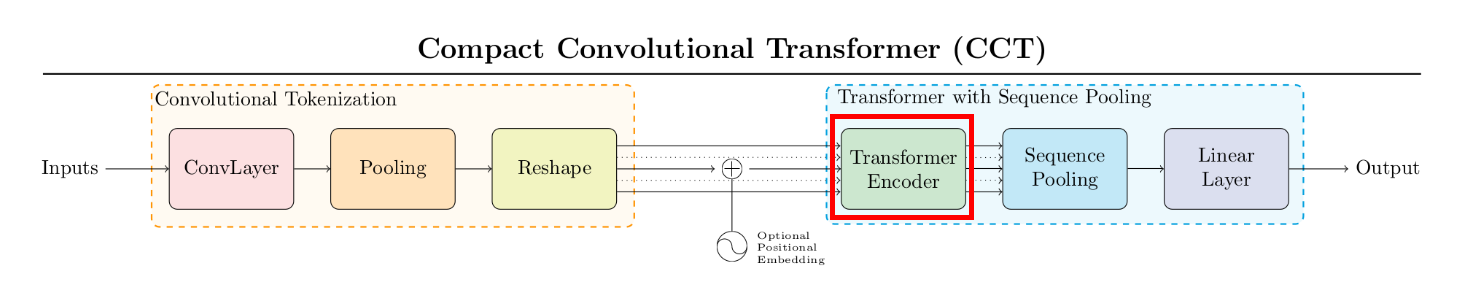
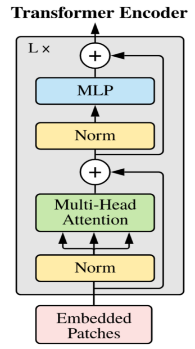

In [6]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=3072, dropout=0.1, #dim_feedforward=2048
                 attention_dropout=0.1, drop_path_rate=0.1):

        super(TransformerEncoderLayer, self).__init__()

        self.pre_norm = nn.LayerNorm(d_model)
        self.self_attn = Attention(dim=d_model, num_heads=nhead,
                                   attention_dropout=attention_dropout, projection_dropout=dropout)


        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.dropout2 = nn.Dropout(dropout)

        self.activation = F.gelu

    def forward(self, x):
        mha = self.self_attn(self.pre_norm(x))
        out = x + mha
        out = self.norm1(out)

        out2 = self.linear2(self.dropout1(self.activation(self.linear1(out))))
        out = out + self.dropout2(out2)
        return out

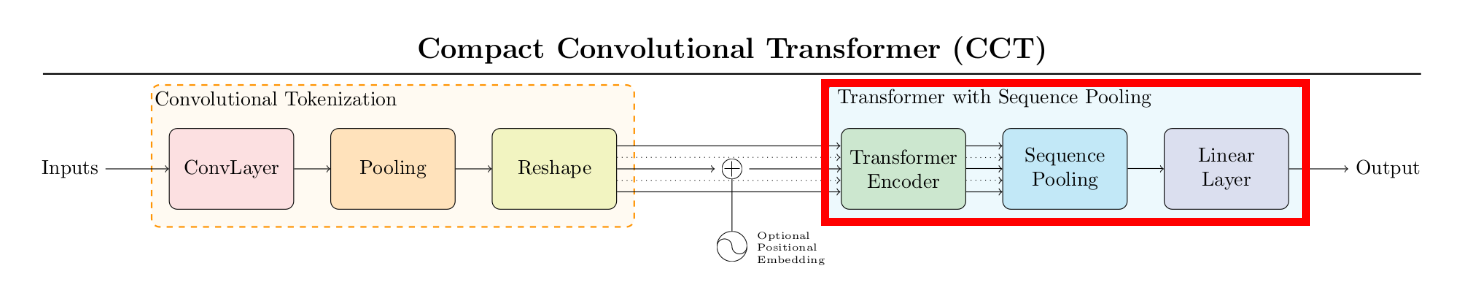

In [7]:
class TransformerClassifier(nn.Module):
    def __init__(self,
                 seq_pool=True,
                 embedding_dim=768,
                 num_layers=12,
                 num_heads=12,
                 mlp_ratio=4.0,
                 num_classes=1000,
                 dropout=0.1,
                 attention_dropout=0.1,
                 stochastic_depth=0.1,
                 positional_embedding='learnable',
                 sequence_length=None):
        super().__init__()

        dim_feedforward = int(embedding_dim * mlp_ratio)
        self.embedding_dim = embedding_dim
        self.sequence_length = sequence_length
        self.seq_pool = seq_pool
        self.num_tokens = 0

        self.attention_pool = nn.Linear(self.embedding_dim, 1)


        if positional_embedding == 'learnable':
            self.positional_emb = nn.Parameter(torch.zeros(1, sequence_length, embedding_dim),
                                                requires_grad=True)
            nn.init.trunc_normal_(self.positional_emb, std=0.2)
        else:
            self.positional_emb = nn.Parameter(self.sinusoidal_embedding(sequence_length, embedding_dim),
                                                requires_grad=False)

        self.dropout = nn.Dropout(p=dropout)

        dpr = [x.item() for x in torch.linspace(0, stochastic_depth, num_layers)]
        self.blocks = nn.ModuleList([
            TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads,
                                    dim_feedforward=dim_feedforward, dropout=dropout,
                                    attention_dropout=attention_dropout, drop_path_rate=dpr[i])
            for i in range(num_layers)])
        self.norm = nn.LayerNorm(embedding_dim)


        self.fc = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        x += self.positional_emb
        x = self.dropout(x)

        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)

        x = torch.matmul(F.softmax(self.attention_pool(x), dim=1).transpose(-1, -2), x).squeeze(-2)

        x = self.fc(x)
        return x


    @staticmethod
    def sinusoidal_embedding(n_channels, dim):
        pe = torch.FloatTensor([[p / (10000 ** (2 * (i // 2) / dim)) for i in range(dim)]
                                for p in range(n_channels)])
        pe[:, 0::2] = torch.sin(pe[:, 0::2])
        pe[:, 1::2] = torch.cos(pe[:, 1::2])
        return pe.unsqueeze(0)

In [30]:
class CCT(nn.Module):
    def __init__(self,
                 img_size=256, #224
                 embedding_dim=256, #768
                 n_input_channels=3,
                 n_conv_layers=2,
                 kernel_size=7,
                 stride=2,
                 padding=3,
                 pooling_kernel_size=3,
                 pooling_stride=2,
                 pooling_padding=1,
                 dropout=0.,
                 attention_dropout=0.,
                 stochastic_depth=0.1,
                 num_layers=6, #14
                 num_heads=4, #6
                 mlp_ratio=2.0, #4
                 num_classes=16,
                 positional_embedding='learnable',
                 *args, **kwargs):
        super(CCT, self).__init__()

        self.tokenizer = Tokenizer(n_input_channels=n_input_channels,
                                   n_output_channels=embedding_dim,
                                   kernel_size=kernel_size,
                                   stride=stride,
                                   padding=padding,
                                   pooling_kernel_size=pooling_kernel_size,
                                   pooling_stride=pooling_stride,
                                   pooling_padding=pooling_padding,
                                   max_pool=True,
                                   activation=nn.ReLU,
                                   n_conv_layers=n_conv_layers,
                                   conv_bias=False)

        self.classifier = TransformerClassifier(
            sequence_length=self.tokenizer.sequence_length(n_channels=n_input_channels,
                                                           height=img_size,
                                                           width=img_size),
            embedding_dim=embedding_dim,
            seq_pool=True,
            dropout=dropout,
            attention_dropout=attention_dropout,
            stochastic_depth=stochastic_depth,
            num_layers=num_layers,
            num_heads=num_heads,
            mlp_ratio=mlp_ratio,
            num_classes=num_classes,
            positional_embedding=positional_embedding
        )

    def forward(self, x):
        x = self.tokenizer(x)
        return self.classifier(x)

In [31]:
model = CCT()

In [32]:
torchinfo.summary(model, (3, 256, 256), batch_dim = 0, col_names = ("input_size", "output_size", "num_params", "kernel_size", "mult_adds"), verbose = 0)

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
CCT                                           [1, 3, 256, 256]          [1, 16]                   --                        --                        --
├─Tokenizer: 1-1                              [1, 3, 256, 256]          [1, 256, 256]             --                        --                        --
│    └─Sequential: 2-1                        [1, 3, 256, 256]          [1, 256, 16, 16]          --                        --                        --
│    │    └─Sequential: 3-1                   [1, 3, 256, 256]          [1, 64, 64, 64]           9,408                     --                        154,140,672
│    │    └─Sequential: 3-2                   [1, 64, 64, 64]           [1, 256, 16, 16]          802,816                   --                        822,083,584
│    └─Flatten: 2-2                           [1, 256, 16

# Train

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
num_clases = len(dataset.classes)
print(num_clases)
print(dataset.classes)

16
['F_Banana', 'F_Lemon', 'F_Lulo', 'F_Mango', 'F_Orange', 'F_Strawberry', 'F_Tamarillo', 'F_Tomato', 'S_Banana', 'S_Lemon', 'S_Lulo', 'S_Mango', 'S_Orange', 'S_Strawberry', 'S_Tamarillo', 'S_Tomato']


In [11]:
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)

criterion = nn.CrossEntropyLoss()
#criterion = nn.MSELoss()

num_epochs = 20

In [12]:
def validate(model, test_dataloader):
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    for int, data in enumerate(test_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        output = model(data)
        loss = criterion(output, target)

        val_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        val_running_correct += (preds == target).sum().item()

    val_loss = val_running_loss/len(test_dataloader.dataset)
    val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)
    print(f'Train Loss: {val_loss:.4f}, Train Acc: {val_accuracy:.2f}')

    return val_loss, val_accuracy

In [13]:
def train(model, train_dataloader):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in enumerate(train_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}')

    return train_loss, train_accuracy

In [19]:
from codecarbon import EmissionsTracker

In [51]:
tracker = EmissionsTracker()
tracker.start()
try:
    train_loss , train_accuracy = [], []
    val_loss , val_accuracy = [], []
    start = time.time()
    for epoch in range(num_epochs):
        train_epoch_loss, train_epoch_accuracy = train(model, train_loader)
        val_epoch_loss, val_epoch_accuracy = validate(model, valid_loader)
        train_loss.append(train_epoch_loss)
        train_accuracy.append(train_epoch_accuracy)
        val_loss.append(val_epoch_loss)
        val_accuracy.append(val_epoch_accuracy)
    end = time.time()
    print((end-start)/60, 'minutes')

finally:
     tracker.stop()

[codecarbon INFO @ 23:17:56] [setup] RAM Tracking...
[codecarbon INFO @ 23:17:56] [setup] GPU Tracking...
[codecarbon INFO @ 23:17:56] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 23:17:56] [setup] CPU Tracking...
[codecarbon WARNING @ 23:17:56] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 23:17:57] We saw that you have a 13th Gen Intel(R) Core(TM) i7-13700KF but we don't know it. Please contact us.
[codecarbon INFO @ 23:17:57] CPU Model on constant consumption mode: 13th Gen Intel(R) Core(TM) i7-13700KF
[codecarbon INFO @ 23:17:57] >>> Tracker's metadata:
[codecarbon INFO @ 23:17:57]   Platform system: Linux-5.15.153.1-microsoft-standard-WSL2+-x86_64-with-glibc2.35
[codecarbon INFO @ 23:17:57]   Python version: 3.10.12
[codecarbon INFO @ 23:17:57]   CodeCarbon version: 2.5.0
[codecarbon INFO @ 23:17:57]   Available RAM : 15.527 GB
[codecarbon INFO @ 23:17:57]   CPU count: 24
[codecarbon INFO @ 23:17:57]   CPU model: 13th Gen Intel(R) Core(T

Train Loss: 0.0112, Train Acc: 6.40
Train Loss: 0.0114, Train Acc: 6.34


[codecarbon INFO @ 23:18:27] Energy consumed for RAM : 0.000049 kWh. RAM Power : 5.822477817535401 W
[codecarbon INFO @ 23:18:27] Energy consumed for all GPUs : 0.001343 kWh. Total GPU Power : 152.34005799923514 W
[codecarbon INFO @ 23:18:27] Energy consumed for all CPUs : 0.000355 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:18:27] 0.001747 kWh of electricity used since the beginning.


Train Loss: 0.0108, Train Acc: 9.45
Train Loss: 0.0111, Train Acc: 9.38


[codecarbon INFO @ 23:18:42] Energy consumed for RAM : 0.000073 kWh. RAM Power : 5.822477817535401 W
[codecarbon INFO @ 23:18:42] Energy consumed for all GPUs : 0.001973 kWh. Total GPU Power : 151.6009728180348 W
[codecarbon INFO @ 23:18:42] Energy consumed for all CPUs : 0.000532 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:18:42] 0.002577 kWh of electricity used since the beginning.


Train Loss: 0.0103, Train Acc: 13.00


[codecarbon INFO @ 23:18:57] Energy consumed for RAM : 0.000097 kWh. RAM Power : 5.822477817535401 W
[codecarbon INFO @ 23:18:57] Energy consumed for all GPUs : 0.002667 kWh. Total GPU Power : 166.7300453328309 W
[codecarbon INFO @ 23:18:57] Energy consumed for all CPUs : 0.000708 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:18:57] 0.003472 kWh of electricity used since the beginning.


Train Loss: 0.0103, Train Acc: 16.19


[codecarbon INFO @ 23:19:12] Energy consumed for RAM : 0.000121 kWh. RAM Power : 5.822477817535401 W
[codecarbon INFO @ 23:19:12] Energy consumed for all GPUs : 0.003364 kWh. Total GPU Power : 167.5119989973598 W
[codecarbon INFO @ 23:19:12] Energy consumed for all CPUs : 0.000886 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:19:12] 0.004371 kWh of electricity used since the beginning.


Train Loss: 0.0093, Train Acc: 22.17
Train Loss: 0.0087, Train Acc: 29.94


[codecarbon INFO @ 23:19:27] Energy consumed for RAM : 0.000145 kWh. RAM Power : 5.822477817535401 W
[codecarbon INFO @ 23:19:27] Energy consumed for all GPUs : 0.004011 kWh. Total GPU Power : 155.33327863639153 W
[codecarbon INFO @ 23:19:27] Energy consumed for all CPUs : 0.001063 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:19:27] 0.005219 kWh of electricity used since the beginning.


Train Loss: 0.0064, Train Acc: 45.63
Train Loss: 0.0047, Train Acc: 59.22


[codecarbon INFO @ 23:19:42] Energy consumed for RAM : 0.000170 kWh. RAM Power : 5.822477817535401 W
[codecarbon INFO @ 23:19:42] Energy consumed for all GPUs : 0.004656 kWh. Total GPU Power : 154.91548341870677 W
[codecarbon INFO @ 23:19:42] Energy consumed for all CPUs : 0.001240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:19:42] 0.006065 kWh of electricity used since the beginning.


Train Loss: 0.0043, Train Acc: 61.00


[codecarbon INFO @ 23:19:57] Energy consumed for RAM : 0.000194 kWh. RAM Power : 5.822477817535401 W
[codecarbon INFO @ 23:19:57] Energy consumed for all GPUs : 0.005374 kWh. Total GPU Power : 172.36414544113686 W
[codecarbon INFO @ 23:19:57] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:19:57] 0.006984 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:19:57] 0.014929 g.CO2eq/s mean an estimation of 470.787479468507 kg.CO2eq/year


Train Loss: 0.0037, Train Acc: 66.69


[codecarbon INFO @ 23:20:12] Energy consumed for RAM : 0.000218 kWh. RAM Power : 5.822477817535401 W
[codecarbon INFO @ 23:20:12] Energy consumed for all GPUs : 0.006063 kWh. Total GPU Power : 165.53508674438524 W
[codecarbon INFO @ 23:20:12] Energy consumed for all CPUs : 0.001594 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:20:12] 0.007875 kWh of electricity used since the beginning.


Train Loss: 0.0031, Train Acc: 71.80
Train Loss: 0.0027, Train Acc: 76.88


[codecarbon INFO @ 23:20:27] Energy consumed for RAM : 0.000242 kWh. RAM Power : 5.822477817535401 W
[codecarbon INFO @ 23:20:27] Energy consumed for all GPUs : 0.006707 kWh. Total GPU Power : 154.43619847571273 W
[codecarbon INFO @ 23:20:27] Energy consumed for all CPUs : 0.001771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:20:27] 0.008720 kWh of electricity used since the beginning.


Train Loss: 0.0024, Train Acc: 78.99
Train Loss: 0.0019, Train Acc: 84.47


[codecarbon INFO @ 23:20:42] Energy consumed for RAM : 0.000267 kWh. RAM Power : 5.822477817535401 W
[codecarbon INFO @ 23:20:42] Energy consumed for all GPUs : 0.007360 kWh. Total GPU Power : 156.86093219465698 W
[codecarbon INFO @ 23:20:42] Energy consumed for all CPUs : 0.001948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:20:42] 0.009574 kWh of electricity used since the beginning.


Train Loss: 0.0018, Train Acc: 83.93


[codecarbon INFO @ 23:20:57] Energy consumed for RAM : 0.000291 kWh. RAM Power : 5.822477817535401 W
[codecarbon INFO @ 23:20:57] Energy consumed for all GPUs : 0.008099 kWh. Total GPU Power : 177.452627008517 W
[codecarbon INFO @ 23:20:57] Energy consumed for all CPUs : 0.002125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:20:57] 0.010515 kWh of electricity used since the beginning.


Train Loss: 0.0017, Train Acc: 85.34


[codecarbon INFO @ 23:21:12] Energy consumed for RAM : 0.000315 kWh. RAM Power : 5.822477817535401 W
[codecarbon INFO @ 23:21:12] Energy consumed for all GPUs : 0.008772 kWh. Total GPU Power : 161.50692146363124 W
[codecarbon INFO @ 23:21:12] Energy consumed for all CPUs : 0.002302 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:21:12] 0.011389 kWh of electricity used since the beginning.


Train Loss: 0.0014, Train Acc: 87.87
Train Loss: 0.0014, Train Acc: 88.41


[codecarbon INFO @ 23:21:27] Energy consumed for RAM : 0.000339 kWh. RAM Power : 5.822477817535401 W
[codecarbon INFO @ 23:21:27] Energy consumed for all GPUs : 0.009418 kWh. Total GPU Power : 155.04204965658687 W
[codecarbon INFO @ 23:21:27] Energy consumed for all CPUs : 0.002479 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:21:27] 0.012236 kWh of electricity used since the beginning.


Train Loss: 0.0011, Train Acc: 90.98
Train Loss: 0.0008, Train Acc: 93.53


[codecarbon INFO @ 23:21:42] Energy consumed for RAM : 0.000364 kWh. RAM Power : 5.822477817535401 W
[codecarbon INFO @ 23:21:42] Energy consumed for all GPUs : 0.010076 kWh. Total GPU Power : 158.07133378869025 W
[codecarbon INFO @ 23:21:42] Energy consumed for all CPUs : 0.002656 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:21:42] 0.013096 kWh of electricity used since the beginning.


Train Loss: 0.0009, Train Acc: 92.10


[codecarbon INFO @ 23:21:57] Energy consumed for RAM : 0.000388 kWh. RAM Power : 5.822477817535401 W
[codecarbon INFO @ 23:21:57] Energy consumed for all GPUs : 0.010833 kWh. Total GPU Power : 181.52613726109715 W
[codecarbon INFO @ 23:21:57] Energy consumed for all CPUs : 0.002833 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:21:57] 0.014054 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:21:57] 0.015111 g.CO2eq/s mean an estimation of 476.5552755913668 kg.CO2eq/year


Train Loss: 0.0012, Train Acc: 88.81


[codecarbon INFO @ 23:22:12] Energy consumed for RAM : 0.000412 kWh. RAM Power : 5.822477817535401 W
[codecarbon INFO @ 23:22:12] Energy consumed for all GPUs : 0.011496 kWh. Total GPU Power : 159.23043847464876 W
[codecarbon INFO @ 23:22:12] Energy consumed for all CPUs : 0.003010 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:22:12] 0.014918 kWh of electricity used since the beginning.


Train Loss: 0.0008, Train Acc: 93.35
Train Loss: 0.0006, Train Acc: 95.38


[codecarbon INFO @ 23:22:27] Energy consumed for RAM : 0.000436 kWh. RAM Power : 5.822477817535401 W
[codecarbon INFO @ 23:22:27] Energy consumed for all GPUs : 0.012149 kWh. Total GPU Power : 156.98740568862124 W
[codecarbon INFO @ 23:22:27] Energy consumed for all CPUs : 0.003187 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:22:27] 0.015773 kWh of electricity used since the beginning.


Train Loss: 0.0006, Train Acc: 95.05
Train Loss: 0.0007, Train Acc: 95.09


[codecarbon INFO @ 23:22:42] Energy consumed for RAM : 0.000461 kWh. RAM Power : 5.822477817535401 W
[codecarbon INFO @ 23:22:42] Energy consumed for all GPUs : 0.012783 kWh. Total GPU Power : 152.06621880914216 W
[codecarbon INFO @ 23:22:42] Energy consumed for all CPUs : 0.003364 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:22:42] 0.016608 kWh of electricity used since the beginning.


Train Loss: 0.0005, Train Acc: 96.24


[codecarbon INFO @ 23:22:57] Energy consumed for RAM : 0.000485 kWh. RAM Power : 5.822477817535401 W
[codecarbon INFO @ 23:22:57] Energy consumed for all GPUs : 0.013547 kWh. Total GPU Power : 183.4868963916993 W
[codecarbon INFO @ 23:22:57] Energy consumed for all CPUs : 0.003541 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:22:57] 0.017573 kWh of electricity used since the beginning.


Train Loss: 0.0005, Train Acc: 97.06


[codecarbon INFO @ 23:23:12] Energy consumed for RAM : 0.000509 kWh. RAM Power : 5.822477817535401 W
[codecarbon INFO @ 23:23:12] Energy consumed for all GPUs : 0.014189 kWh. Total GPU Power : 154.1311092724222 W
[codecarbon INFO @ 23:23:12] Energy consumed for all CPUs : 0.003719 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:23:12] 0.018417 kWh of electricity used since the beginning.


Train Loss: 0.0004, Train Acc: 96.35
Train Loss: 0.0010, Train Acc: 91.91


[codecarbon INFO @ 23:23:27] Energy consumed for RAM : 0.000533 kWh. RAM Power : 5.822477817535401 W
[codecarbon INFO @ 23:23:27] Energy consumed for all GPUs : 0.014825 kWh. Total GPU Power : 152.62209238352634 W
[codecarbon INFO @ 23:23:27] Energy consumed for all CPUs : 0.003896 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:23:27] 0.019254 kWh of electricity used since the beginning.


Train Loss: 0.0004, Train Acc: 97.05
Train Loss: 0.0005, Train Acc: 96.25


[codecarbon INFO @ 23:23:42] Energy consumed for RAM : 0.000558 kWh. RAM Power : 5.822477817535401 W
[codecarbon INFO @ 23:23:42] Energy consumed for all GPUs : 0.015474 kWh. Total GPU Power : 156.02860744896347 W
[codecarbon INFO @ 23:23:42] Energy consumed for all CPUs : 0.004073 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:23:42] 0.020104 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:23:57] Energy consumed for RAM : 0.000582 kWh. RAM Power : 5.822477817535401 W
[codecarbon INFO @ 23:23:57] Energy consumed for all GPUs : 0.016244 kWh. Total GPU Power : 184.99971572818083 W
[codecarbon INFO @ 23:23:57] Energy consumed for all CPUs : 0.004250 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:23:57] 0.021076 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:23:57] 0.015010 g.CO2eq/s mean an estimation of 473.37104627598416 kg.CO2eq/year


Train Loss: 0.0003, Train Acc: 97.99
Train Loss: 0.0005, Train Acc: 96.38


[codecarbon INFO @ 23:24:12] Energy consumed for RAM : 0.000606 kWh. RAM Power : 5.822477817535401 W
[codecarbon INFO @ 23:24:12] Energy consumed for all GPUs : 0.016883 kWh. Total GPU Power : 153.45009992536785 W
[codecarbon INFO @ 23:24:12] Energy consumed for all CPUs : 0.004427 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:24:12] 0.021916 kWh of electricity used since the beginning.


Train Loss: 0.0003, Train Acc: 97.95
Train Loss: 0.0003, Train Acc: 97.75


[codecarbon INFO @ 23:24:27] Energy consumed for RAM : 0.000630 kWh. RAM Power : 5.822477817535401 W
[codecarbon INFO @ 23:24:27] Energy consumed for all GPUs : 0.017525 kWh. Total GPU Power : 154.21831813746317 W
[codecarbon INFO @ 23:24:27] Energy consumed for all CPUs : 0.004604 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:24:27] 0.022759 kWh of electricity used since the beginning.


Train Loss: 0.0002, Train Acc: 98.98


[codecarbon INFO @ 23:24:42] Energy consumed for RAM : 0.000653 kWh. RAM Power : 5.822477817535401 W
[codecarbon INFO @ 23:24:42] Energy consumed for all GPUs : 0.018154 kWh. Total GPU Power : 159.05164250398803 W
[codecarbon INFO @ 23:24:42] Energy consumed for all CPUs : 0.004772 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 23:24:42] 0.023579 kWh of electricity used since the beginning.


Train Loss: 0.0003, Train Acc: 98.34
6.737522915999095 minutes


In [14]:
def Show_Weight(out, labels, ax):
  for j in range(len(ax)):
        ax[j].imshow(transforms.ToPILImage()(out[j]))
        ax[j].set_title(labels[j])
        ax[j].axis('off')

def concat_labels(true_label, pred_label):
  concat = []
  for i in range(len(true_label)):
    concat.append('Etiqueta Real  : '+true_label[i]+
                '\nEtiqueta Predicha: '+pred_label[i])
  return concat

In [15]:
batch_size_test = 5
test_loader = DataLoader(valid_dataset, batch_size_test, shuffle=True)
dataiter = iter(test_loader)

In [23]:
model.load_state_dict(torch.load("CCT_model_1.pth"))

<All keys matched successfully>

In [24]:

image1, label = next(dataiter)
model.eval()
image1 = image1.to(device)
salida = model(image1)
_, pred = torch.max(salida.data, 1)

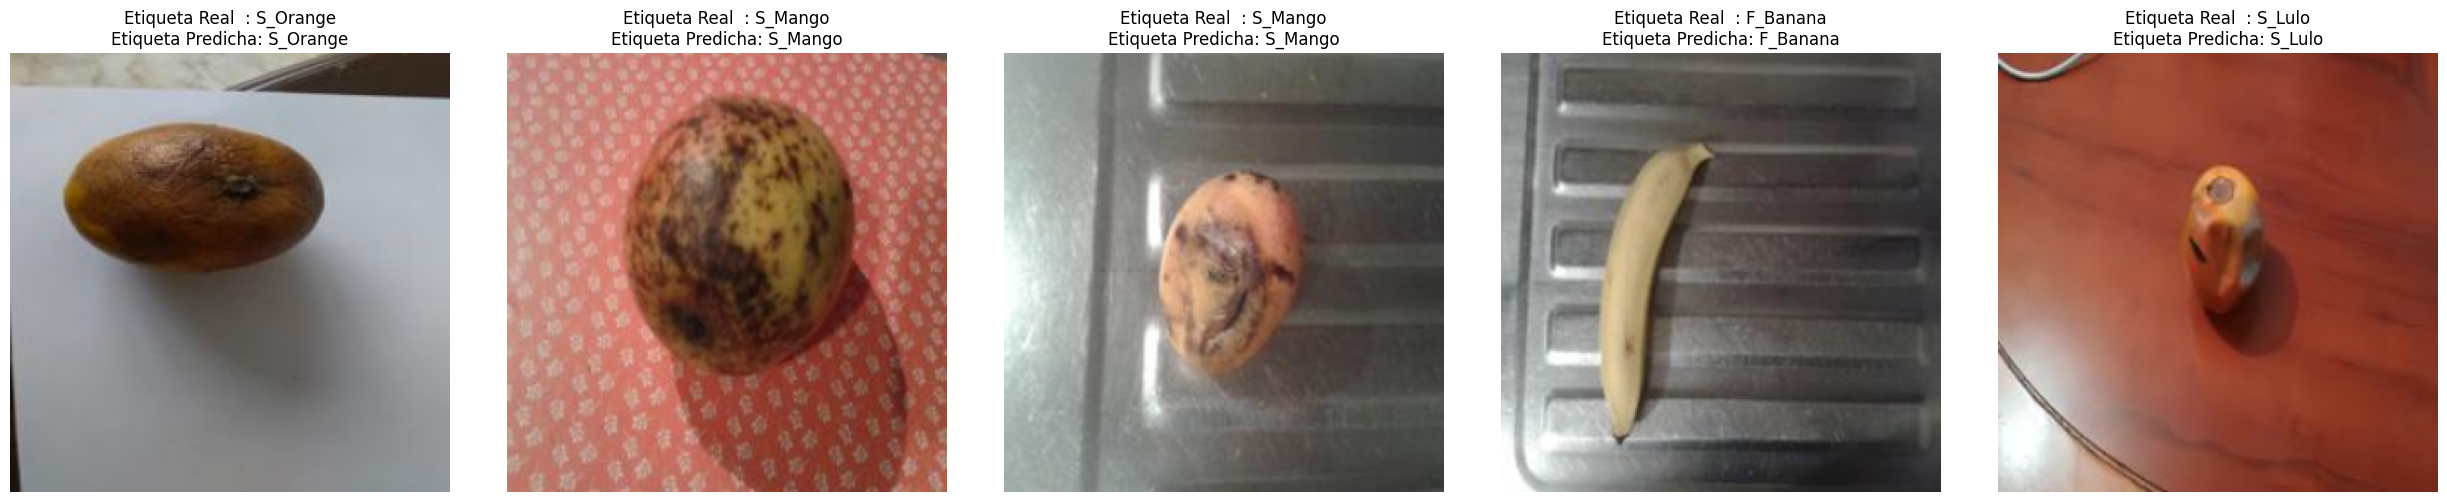

In [25]:
with torch.no_grad():
  y_true_name = [dataset.classes[label[idx]] for idx in range(batch_size_test)]
  y_pred_name = [dataset.classes[pred[idx]] for idx in range(batch_size_test)]

  test_c=concat_labels(y_true_name,y_pred_name)

  fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25, 25))
  fig.tight_layout(h_pad=2)
  Show_Weight(image1[0:5], test_c, ax)

  plt.subplots_adjust(top=20)
  plt.show()

In [27]:
test_acc=0

with torch.no_grad():
    #Iterating over the training dataset in batches
    for i, (images, labels) in enumerate(valid_loader):

        images = images.to(device)
        y_true = labels.to(device)

        #Calculating outputs for the batch being iterated
        outputs = model(images)

        #Calculated prediction labels from models
        _, y_pred = torch.max(outputs.data, 1)

        #Comparing predicted and true labels
        test_acc += (y_pred == y_true).sum().item()

    print(f"Test Precision = {100 * test_acc / len(valid_loader.dataset)} %")

Test Precision = 96.59375 %


# Test

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from torchmetrics import F1Score

In [ ]:
batch_size = 256
test_loader = DataLoader(valid_dataset, batch_size, shuffle=False, num_workers=4)

y_pred = []
y_true = []

for inputs, labels in test_loader:
        inputs = inputs.to(device)

        output = model(inputs)

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels)

pred_ = torch.tensor(y_pred)
true_ = torch.tensor(y_true)

f1 = F1Score(num_classes=16, task="multiclass")
print("F-Score: ", f1(pred_, true_))

F-Score:  tensor(0.9659)


<Axes: >

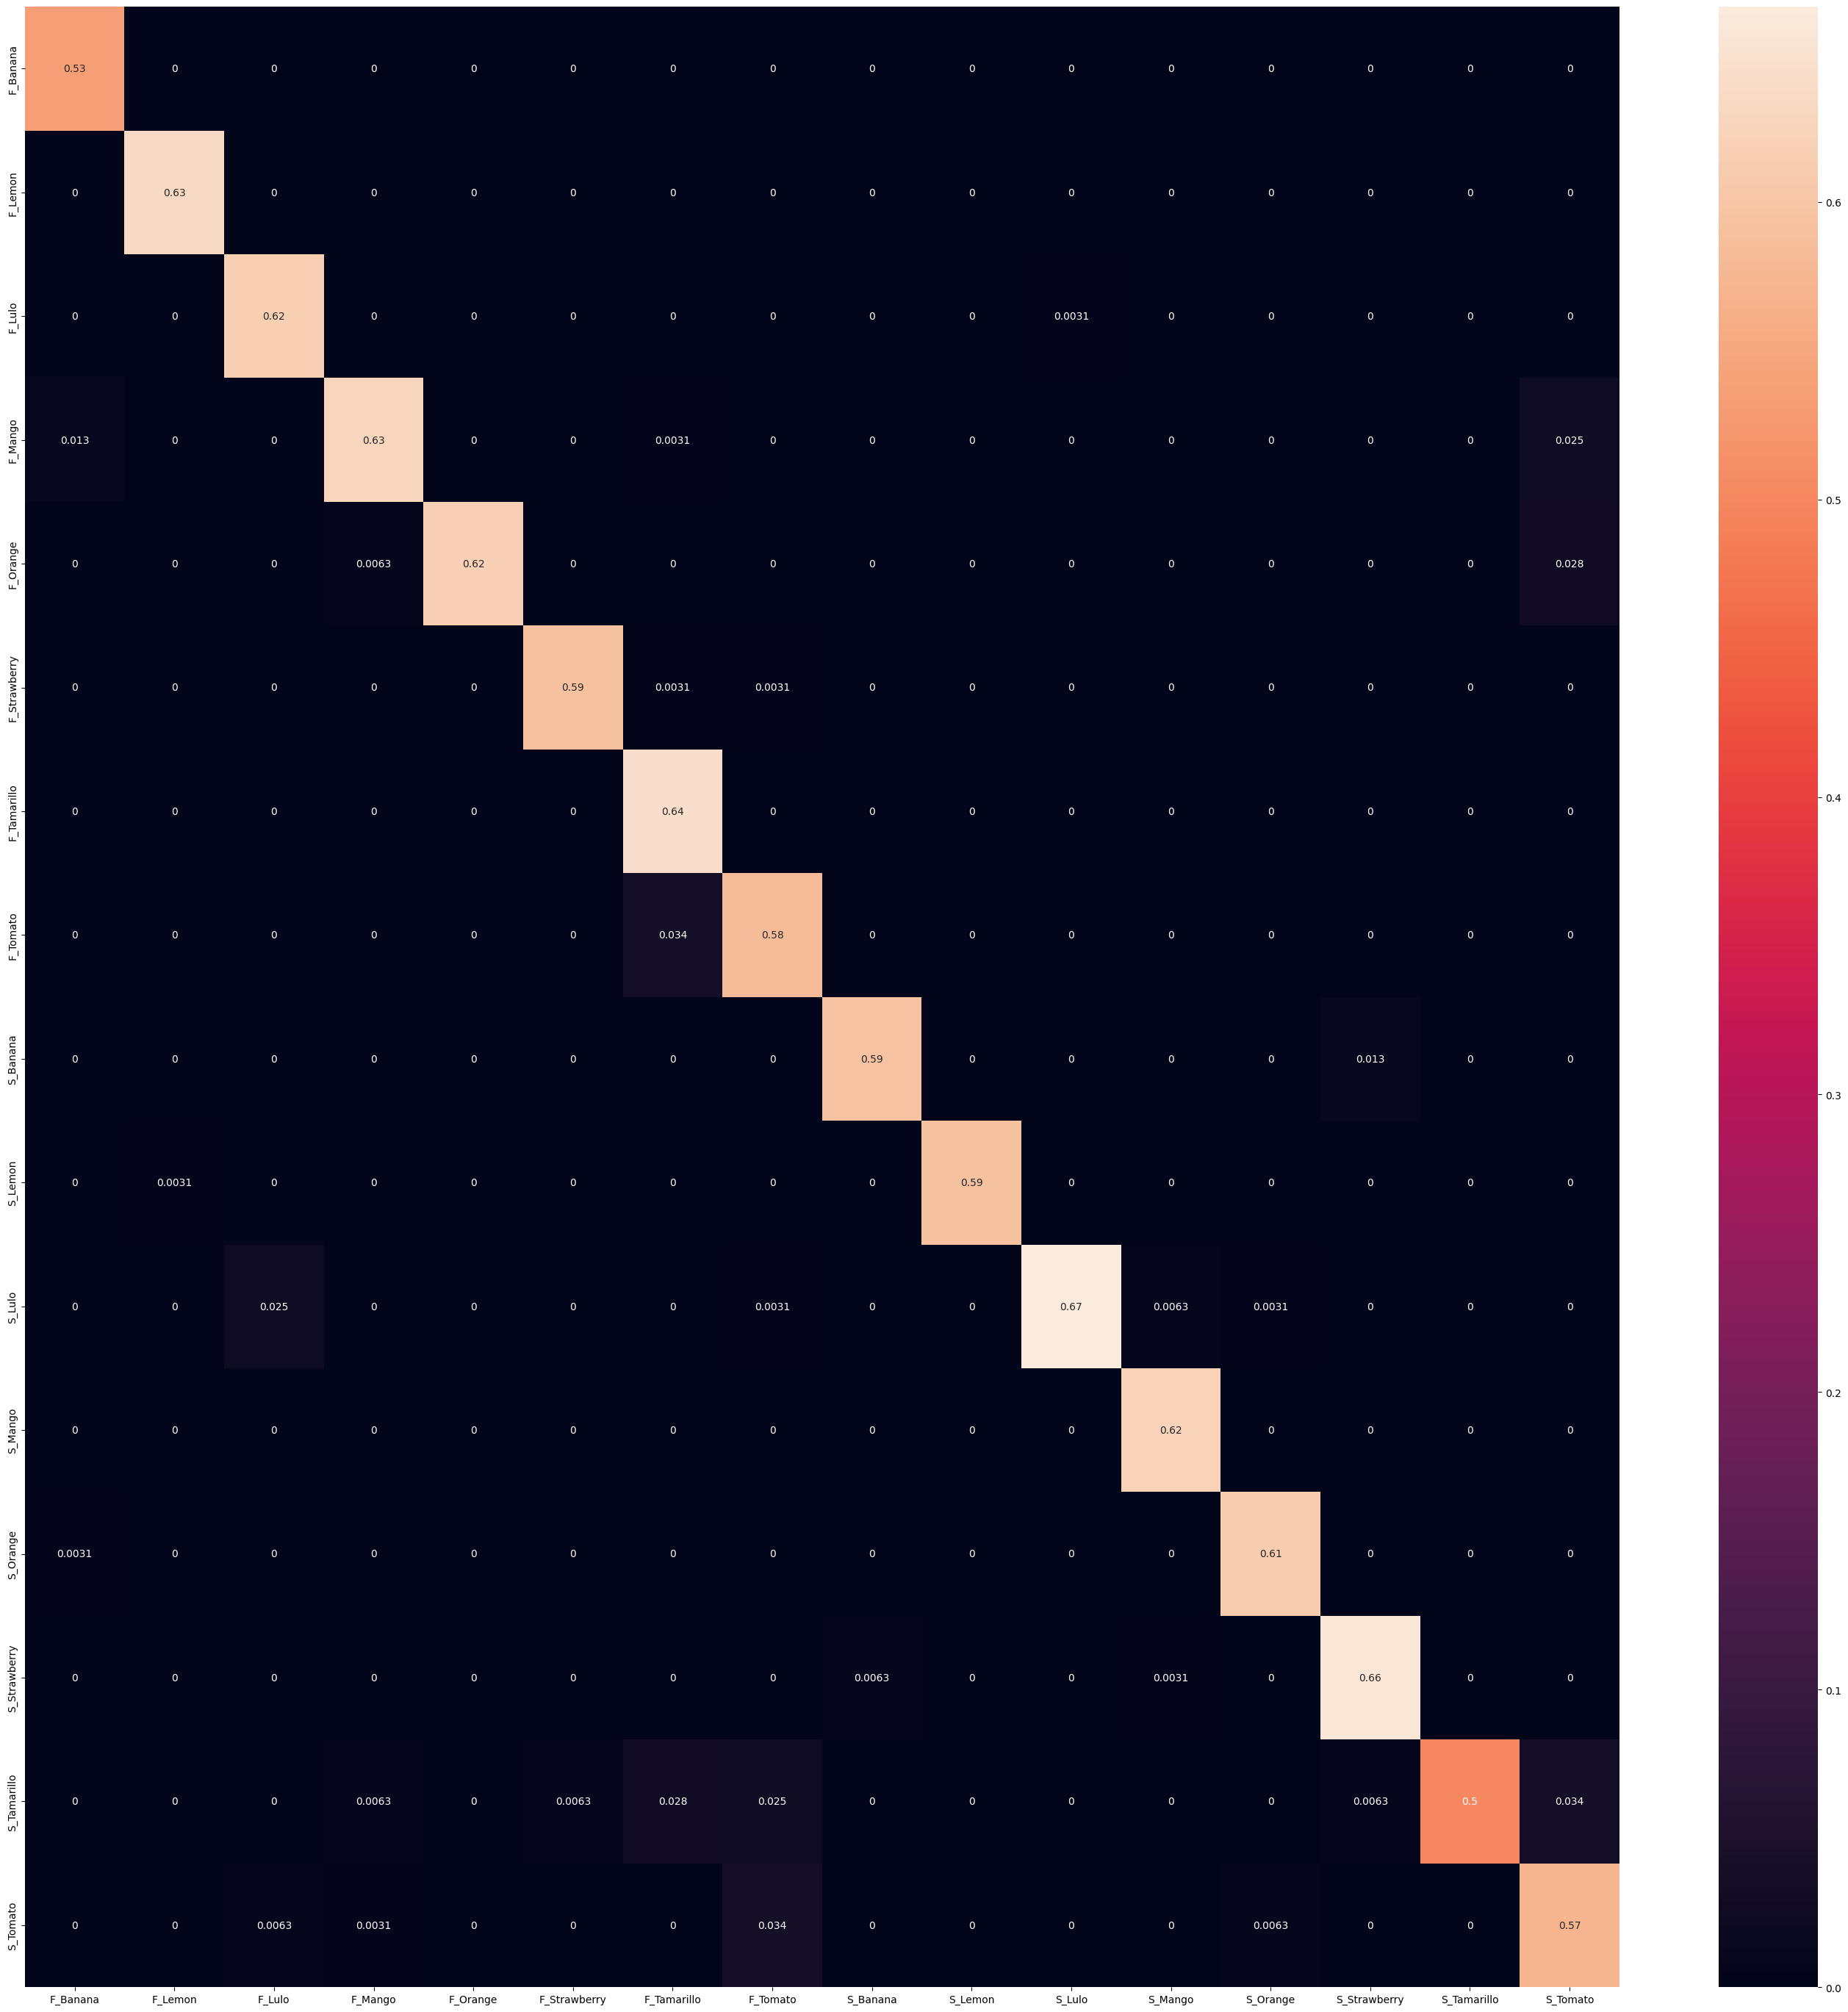

In [ ]:
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in dataset.classes],
                     columns = [i for i in dataset.classes])
plt.figure(figsize = (35,35))
sn.heatmap(df_cm, annot=True)

In [ ]:
PATH = 'CCT_model_1.pth'
torch.save(model.state_dict(), PATH)